## Imports ##

In [176]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


In [178]:

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split


In [108]:
retail = pd.read_csv('/Users/randinho/Desktop/Inventory Optimization/retail_store_inventory.csv')
retail.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [11]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [67]:
retail.shape

(73100, 15)

In [15]:
retail.describe()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


In [110]:
# Impute missing numerical values with the mean
numerical_columns = ['Inventory Level', 'Units Sold', 'Units Ordered', 
                     'Demand Forecast', 'Price', 'Discount', 'Competitor Pricing']
retail[numerical_columns] = retail[numerical_columns].apply(lambda col: col.fillna(col.mean()))

# Impute missing categorical values with the mode
categorical_columns = ['Date', 'Store ID', 'Product ID', 'Category', 
                       'Region', 'Weather Condition', 'Holiday/Promotion', 'Seasonality']
retail[categorical_columns] = retail[categorical_columns].apply(lambda col: col.fillna(col.mode()[0]))


In [112]:
# Parse the 'Date' column as datetime
retail["Date"] = pd.to_datetime(retail["Date"], errors='coerce') #handle datatype 
retail["Date"]=pd.to_datetime(retail.Date,format="%Y/%m/%d")


In [114]:
 #Fill missing values with appropriate strategies
retail['Weather Condition'].fillna('Unknown', inplace=True)
retail.fillna(0, inplace=True)

# Inspect unique values in categorical columns
print(retail['Category'].unique())
print(retail['Holiday/Promotion'].unique())

# Convert categorical variables for analysis
retail['Holiday/Promotion'] = retail['Holiday/Promotion'].apply(lambda x: 1 if x == 'Yes' else 0)

['Groceries' 'Toys' 'Electronics' 'Furniture' 'Clothing']
[0 1]


In [116]:
# Check for missing values
print(retail.isnull().sum())

# Fill missing values or drop rows with missing data
retail.fillna(method='ffill', inplace=True)


Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64


In [25]:
retail.dtypes

Date                  datetime64[ns]
Store ID                      object
Product ID                    object
Category                      object
Region                        object
Inventory Level                int64
Units Sold                     int64
Units Ordered                  int64
Demand Forecast              float64
Price                        float64
Discount                       int64
Weather Condition             object
Holiday/Promotion              int64
Competitor Pricing           float64
Seasonality                   object
dtype: object

In [27]:
retail.nunique()

Date                    731
Store ID                  5
Product ID               20
Category                  5
Region                    4
Inventory Level         451
Units Sold              498
Units Ordered           181
Demand Forecast       31608
Price                  8999
Discount                  5
Weather Condition         4
Holiday/Promotion         1
Competitor Pricing     9751
Seasonality               4
dtype: int64

In [29]:
retail.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')

In [118]:
retail

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,0,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,0,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,S005,P0016,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter
73096,2024-01-01,S005,P0017,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Autumn
73097,2024-01-01,S005,P0018,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter
73098,2024-01-01,S005,P0019,Toys,East,374,264,21,270.52,53.14,20,Rainy,0,55.80,Spring


/var/folders/m9/pjpy8v294f5_ytxqg0q6y1d40000gn/T/ipykernel_1999/244532866.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = correlation_data.corr()


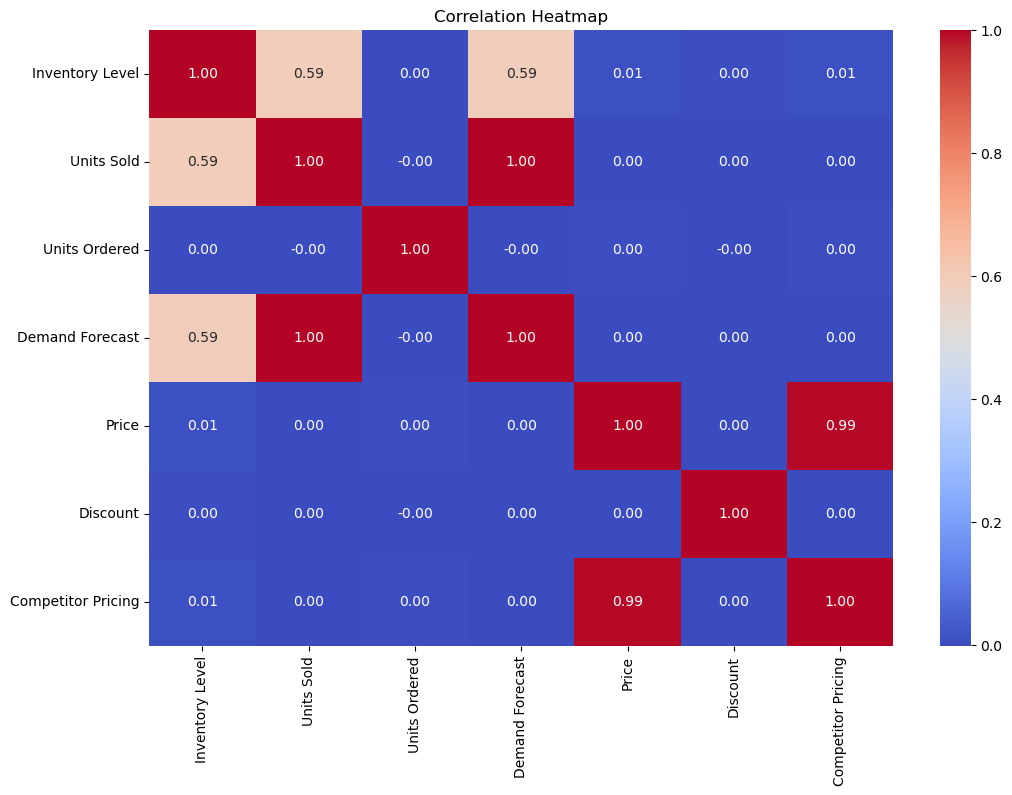

In [120]:
# Combine features and target for correlation analysis
correlation_data = retail.drop(columns=['Date','Holiday/Promotion'])
correlation_matrix = correlation_data.corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

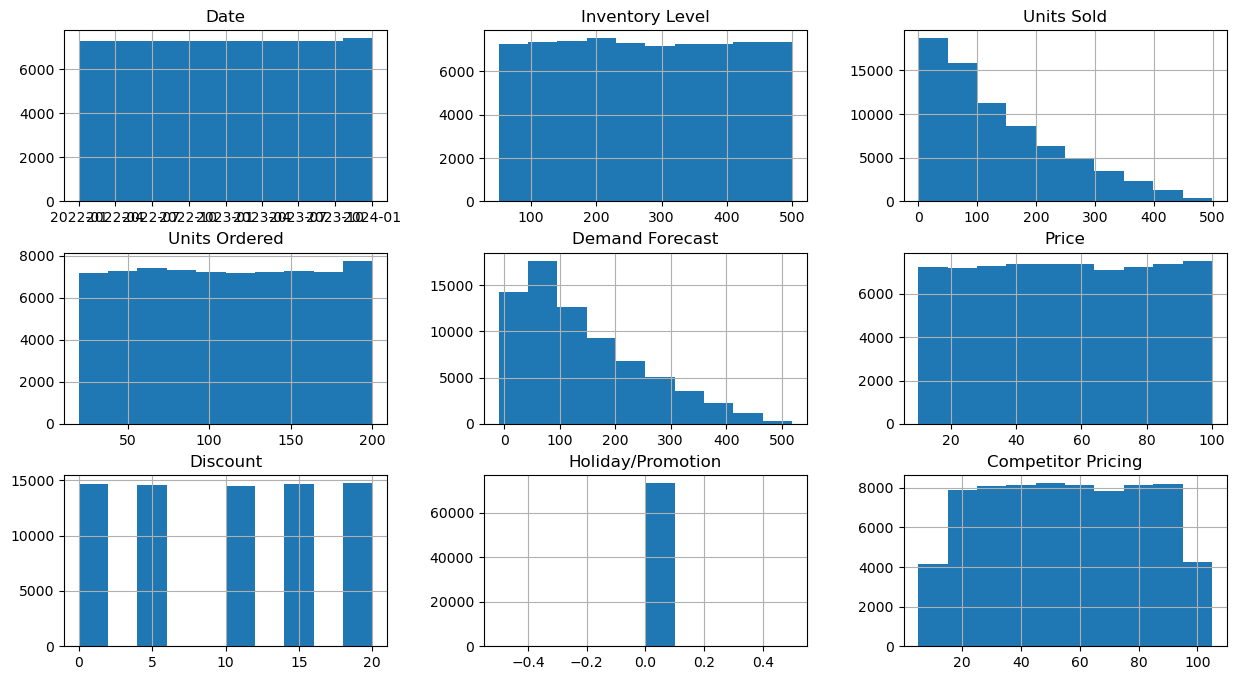

In [122]:
# Show distribution of features

retail.hist(figsize=(15,8))
plt.show()

In [124]:
retail

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,0,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,0,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,S005,P0016,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter
73096,2024-01-01,S005,P0017,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Autumn
73097,2024-01-01,S005,P0018,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter
73098,2024-01-01,S005,P0019,Toys,East,374,264,21,270.52,53.14,20,Rainy,0,55.80,Spring


In [126]:
retail['Units Sold'].describe()

count    73100.000000
mean       136.464870
std        108.919406
min          0.000000
25%         49.000000
50%        107.000000
75%        203.000000
max        499.000000
Name: Units Sold, dtype: float64

##  Data Exploration

## 1.Inventory Analysis

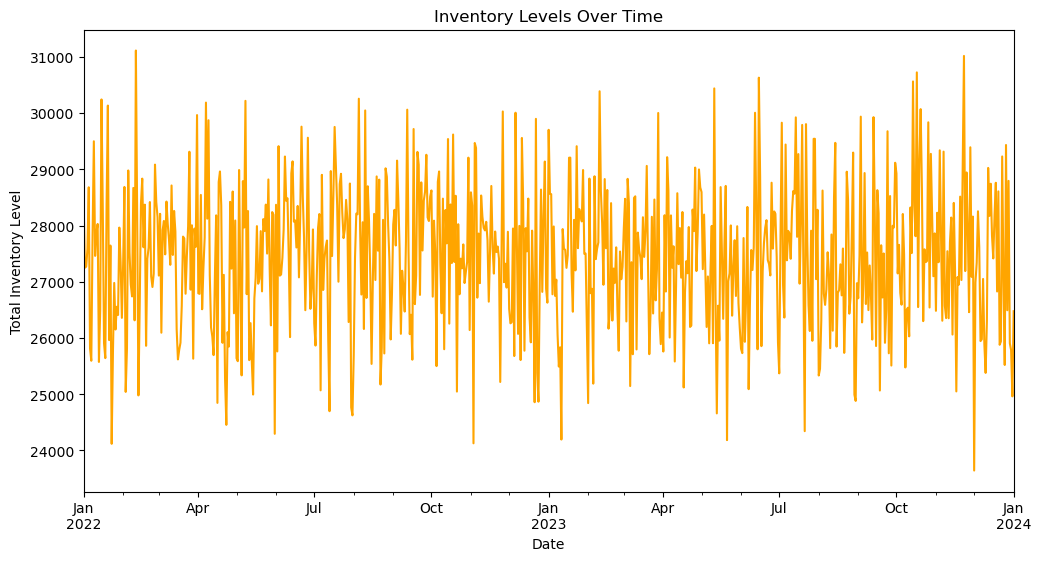

In [128]:
# Plot Inventory Levels Over Time
monthly_inventory = retail.groupby('Date')['Inventory Level'].sum()

plt.figure(figsize=(12, 6))
monthly_inventory.plot(color='orange')
plt.title('Inventory Levels Over Time')
plt.xlabel('Date')
plt.ylabel('Total Inventory Level')
plt.show()

## Sales Analysis

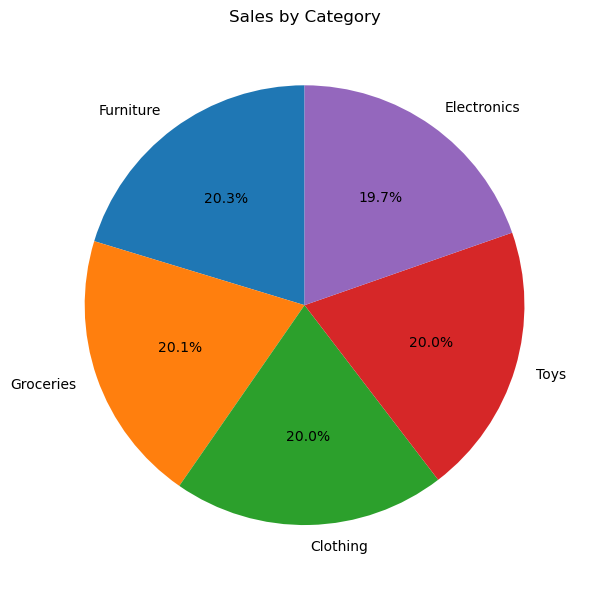

In [130]:
# Grouping data by category and summing up units sold
sales_by_category = retail.groupby('Category')['Units Sold'].sum().sort_values(ascending=False)

# Plot a pie chart
plt.figure(figsize=(10, 6))  # Adjusted figure size
plt.pie(
    sales_by_category, 
    labels=sales_by_category.index, 
    autopct='%1.1f%%', 
    startangle=90
)
plt.title('Sales by Category')
plt.tight_layout()
plt.show()

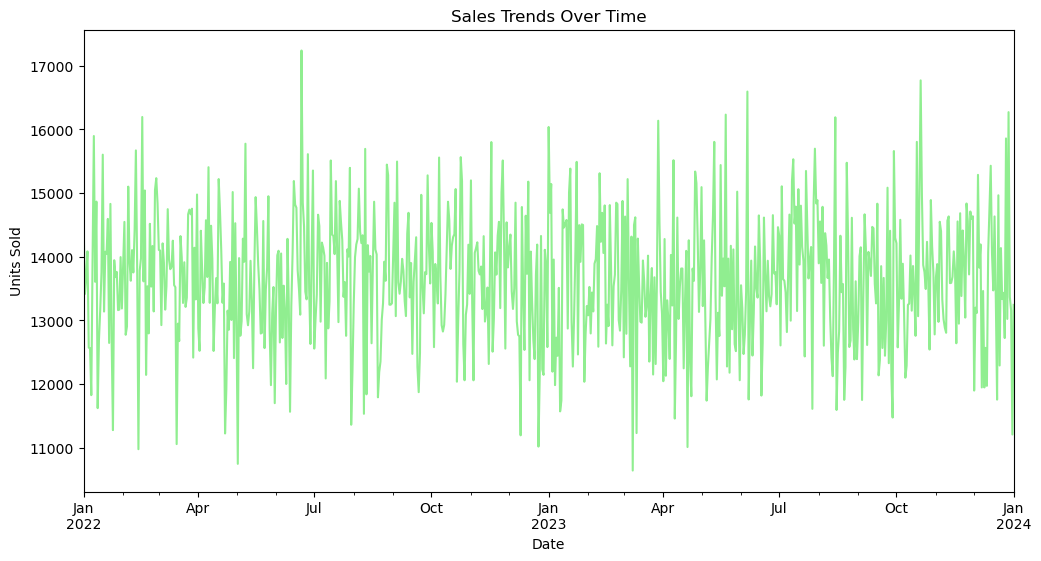

In [132]:
# Plot Units sold Over Time
Total_units_sold = retail.groupby('Date')['Units Sold'].sum()

plt.figure(figsize=(12, 6))
Total_units_sold .plot(color='lightgreen')
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

Based on our plot;

We can see that sales appears to fluctuate around a consistent range (e.g., between 12,000 and 17,000). Also, there doesn’t seem to be upward or downward trend in the average sales over time. The mean appears stable around 14,000

In [134]:
# Encode Categorical Variables

from sklearn.preprocessing import OneHotEncoder

# Define categorical columns to encode (excluding 'Date')
categorical_columns = ['Store ID', 'Product ID', 'Category', 
                       'Region', 'Weather Condition', 
                       'Holiday/Promotion', 'Seasonality']

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Encode categorical variables
encoded_columns = encoder.fit_transform(retail[categorical_columns])

# Convert encoded columns to a DataFrame
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate encoded columns back with the original DataFrame
retail = pd.concat([retail.drop(columns=categorical_columns), encoded_df], axis=1)

# Retain the Date column
print(retail.head())



        Date  Inventory Level  Units Sold  Units Ordered  Demand Forecast  \
0 2022-01-01              231         127             55           135.47   
1 2022-01-01              204         150             66           144.04   
2 2022-01-01              102          65             51            74.02   
3 2022-01-01              469          61            164            62.18   
4 2022-01-01              166          14            135             9.26   

   Price  Discount  Competitor Pricing  Store ID_S001  Store ID_S002  ...  \
0  33.50        20               29.69            1.0            0.0  ...   
1  63.01        20               66.16            1.0            0.0  ...   
2  27.99        10               31.32            1.0            0.0  ...   
3  32.72        10               34.74            1.0            0.0  ...   
4  73.64         0               68.95            1.0            0.0  ...   

   Region_West  Weather Condition_Cloudy  Weather Condition_Rainy  \
0    

/Users/randinho/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [136]:
retail.columns


Index(['Date', 'Inventory Level', 'Units Sold', 'Units Ordered',
       'Demand Forecast', 'Price', 'Discount', 'Competitor Pricing',
       'Store ID_S001', 'Store ID_S002', 'Store ID_S003', 'Store ID_S004',
       'Store ID_S005', 'Product ID_P0001', 'Product ID_P0002',
       'Product ID_P0003', 'Product ID_P0004', 'Product ID_P0005',
       'Product ID_P0006', 'Product ID_P0007', 'Product ID_P0008',
       'Product ID_P0009', 'Product ID_P0010', 'Product ID_P0011',
       'Product ID_P0012', 'Product ID_P0013', 'Product ID_P0014',
       'Product ID_P0015', 'Product ID_P0016', 'Product ID_P0017',
       'Product ID_P0018', 'Product ID_P0019', 'Product ID_P0020',
       'Category_Clothing', 'Category_Electronics', 'Category_Furniture',
       'Category_Groceries', 'Category_Toys', 'Region_East', 'Region_North',
       'Region_South', 'Region_West', 'Weather Condition_Cloudy',
       'Weather Condition_Rainy', 'Weather Condition_Snowy',
       'Weather Condition_Sunny', 'Holiday/Prom

## Base Models 

## Forecasting Demand Using Linear Regression Model

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


X = retail.drop(['Units Sold', 'Date'], axis=1) # Features 
y = retail['Units Sold']


# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model 
lr_model = LinearRegression() 
lr_model.fit(X_train, y_train)

# Make predictions 
y_train_pred = lr_model.predict(X_train) 
y_test_pred = lr_model.predict(X_test)

# Evaluate the model
mae = round(mean_absolute_error(y_test, y_test_pred), 2) 
mse = round(mean_squared_error(y_test, y_test_pred), 2) 
rmse = round(np.sqrt(mse), 2) 
r2 = round(r2_score(y_test, y_test_pred), 2)


print("Linear Regression:")
print(f'Mean Absolute Error (MAE): {mae}') 
print(f'Mean Squared Error (MSE): {mse}') 
print(f'Root Mean Squared Error (RMSE): {rmse}') 
print(f'R² Score: {r2}')



Linear Regression:
Mean Absolute Error (MAE): 7.42
Mean Squared Error (MSE): 74.02
Root Mean Squared Error (RMSE): 8.6
R² Score: 0.99


## Forecasting Demand Using Random Forest Regression Model

In [140]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


X = retail.drop(['Units Sold', 'Date'], axis=1) # Features 
y = retail['Units Sold']


# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regression model 
rf_model = RandomForestRegressor(n_estimators= 100 ,random_state=42) 
rf_model.fit(X_train, y_train)

# Make predictions 
y_train_pred = rf_model.predict(X_train) 
y_test_pred = rf_model.predict(X_test)

# Evaluate the model
mae = round(mean_absolute_error(y_test, y_test_pred), 2) 
mse = round(mean_squared_error(y_test, y_test_pred), 2) 
rmse = round(np.sqrt(mse), 2) 
r2 = round(r2_score(y_test, y_test_pred), 2)


print("Random Forest Regression:")
print(f'Mean Absolute Error (MAE): {mae}') 
print(f'Mean Squared Error (MSE): {mse}') 
print(f'Root Mean Squared Error (RMSE): {rmse}') 
print(f'R² Score: {r2}')




Random Forest Regression:
Mean Absolute Error (MAE): 7.26
Mean Squared Error (MSE): 73.22
Root Mean Squared Error (RMSE): 8.56
R² Score: 0.99


## Time Series Demand Forecasting: 

First, we can visualize demand forecast without applying any models using demand forecast from our dataset.

## Original Demand Forecast (Without Model)

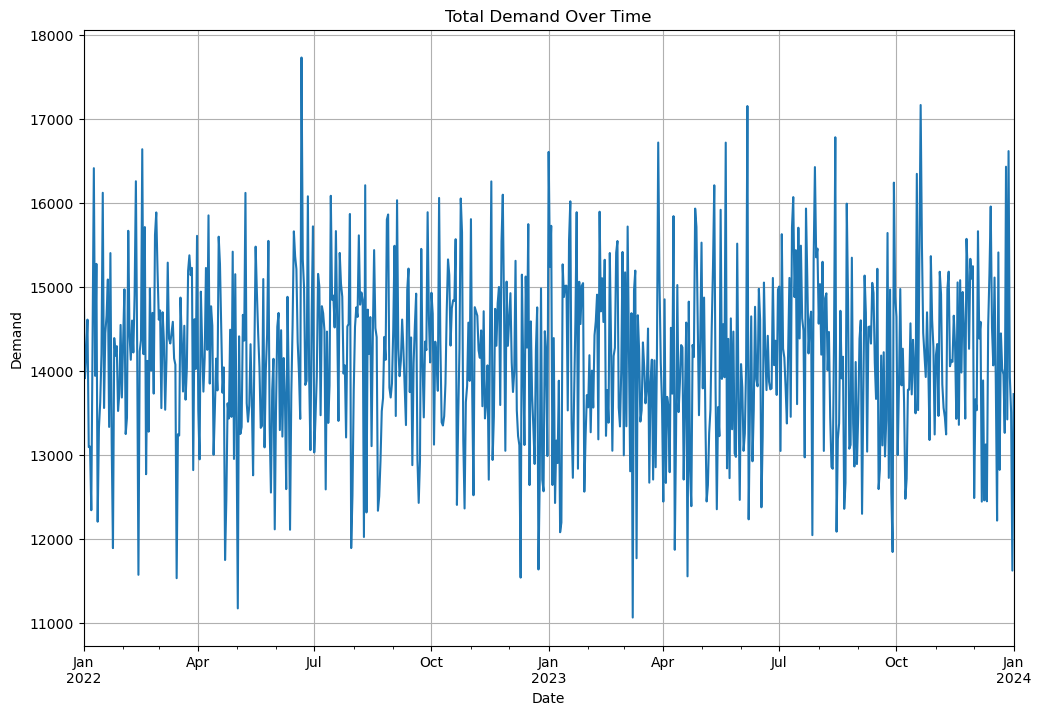

In [244]:
#Aggregate Demand without any Model

demand_data = retail.groupby('Date')['Demand Forecast'].sum()
demand_data.columns = ['Total Demand']

# Plot demand over time
plt.figure(figsize=(12, 8))
demand_data.plot(title='Total Demand Over Time')
plt.ylabel('Demand')
plt.grid()
plt.show()

## Check for Stationarity

## Stationary  Analysis 

Stationarity refers to a time series where statistical properties (mean, variance, autocorrelation) remain constant over time. Based on our plots:
We can see that for Variance:
The demand appears to fluctuate around a consistent range (e.g., between 12,000 and 18,000).This consistency suggests a lack of significant trends in variance, supporting the hypothesis of stationarity. 

Also for the Mean:

There doesn’t seem to be upward or downward trend in the average demand over time. The mean appears stable. This stability is another indication of stationarity.

This suggests that historical demand patterns are reliable predictors of future demand.

We can forecast the demand using models like ARIMA since it relies on stationarity for accurate predictions but just to double check on the issues of stationarity we can use the Augmented Dickey-Fuller (ADF) test to check if the time series is stationary. 

ADF Test: The Augmented Dickey-Fuller test is used to determine whether a time series is stationary or has a unit root (non-stationary).

Test Results:

ADF Statistic: A negative value that indicates how strong the trend is in the time series.
p-value: Indicates whether we can reject the null hypothesis that the series is non-stationary. If the p-value is below 0.05, we can reject the null hypothesis and consider the series stationary.

In [246]:
# Data Preparation for ADF Test
from statsmodels.tsa.stattools import adfuller


# Aggregate Units Sold by Date
time_series = retail.groupby('Date')['Units Sold'].sum()

# ADF test
adf_test = adfuller(time_series)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

if adf_test[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary. Differencing is required.")

ADF Statistic: -26.379506701264116
p-value: 0.0
The time series is stationary.


Since the p-value is much lower than 0.05, we can conclude that the time series is stationary

## ARIMA Model for Demand Forecasting
ARIMA Model: ARIMA stands for AutoRegressive Integrated Moving Average, a model used for forecasting time series data.

# Objective
Fit an ARIMA model to the training data using initial parameters (p=1, d=1, q=2) and train the model to predict future values.
where ;

p:(AutoRegressive part): refers to the number of lag observations included in the model. It indicates how past values influence future predictions.

d:(Differencing part): refers to the number of times the series needs to be differenced to make it stationary.

q:(Moving Average part): refers to the number of lagged forecast errors in the prediction equation.

# Fitting the Model:
We start by setting the parameters (p=1, d=1, q=2) as an initial guess. These values represent a basic for the ARIMA model.

In [248]:
# Model Building (ARIMA)


import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Aggregate Units Sold by Date
time_series = retail.groupby('Date')['Units Sold'].sum()

# Split data into training and testing sets
train_size = int(len(time_series) * 0.8)
train, test = time_series[:train_size], time_series[train_size:]

# Fit ARIMA model on training data
model = ARIMA(train, order=(1, 1, 1))  # Adjust (p, d, q) as needed
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Units Sold   No. Observations:                  584
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4883.724
Date:                Fri, 13 Dec 2024   AIC                           9773.448
Time:                        22:05:54   BIC                           9786.552
Sample:                    01-01-2022   HQIC                          9778.556
                         - 08-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0579      0.038      1.529      0.126      -0.016       0.132
ma.L1         -1.0000      0.759     -1.318      0.188      -2.487       0.487
sigma2      1.056e+06   8.08e+05      1.307      0.1

/Users/randinho/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/randinho/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/randinho/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [252]:

# Generate Predictions for test set
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end , typ='levels')


# Calculate evaluation metrics 
mae = round(mean_absolute_error(test, predictions), 2) 
mse = round(mean_squared_error(test, predictions), 2) 
rmse = round(np.sqrt(mse), 2) 

print("ARIMA Model:")
print(f'Mean Absolute Error (MAE): {mae}') 
print(f'Mean Squared Error (MSE): {mse}') 
print(f'Root Mean Squared Error (RMSE): {rmse}') 



ARIMA Model:
Mean Absolute Error (MAE): 842.13
Mean Squared Error (MSE): 1103221.87
Root Mean Squared Error (RMSE): 1050.34


/Users/randinho/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


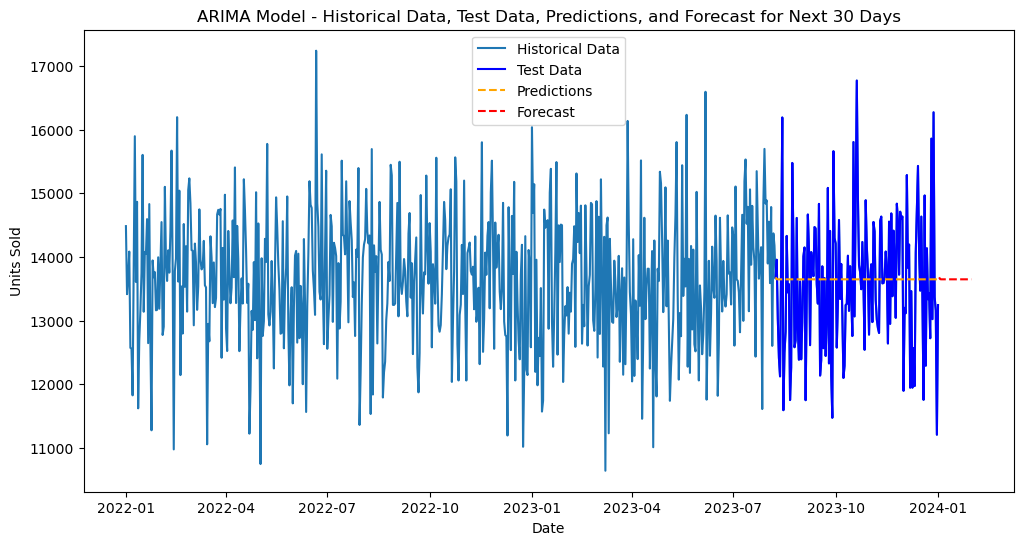

In [145]:
# Future forecast beyond the last date
forecast_steps = 30 
forecast = model_fit.forecast(steps=forecast_steps)


# Create future dates for plotting
last_date = time_series.index[-1] 
future_dates = [last_date + pd.Timedelta(days=x) for x in range(1, forecast_steps + 1)]

# Convert forecast to a Series with the future dates 
forecast_series = pd.Series(forecast, index=future_dates)


# Plot historical data, test predictions, and future forecast
plt.figure(figsize=(12, 6)) 
plt.plot(time_series, label='Historical Data') 
plt.plot(test.index, test, label='Test Data', color='blue') 
plt.plot(test.index, predictions, label='Predictions', linestyle='--', color='orange') 
plt.plot(future_dates, forecast, label='Forecast', linestyle='--', color='red') 
plt.xlabel('Date') 
plt.ylabel('Units Sold') 
plt.title('ARIMA Model - Historical Data, Test Data, Predictions, and Forecast for Next 30 Days') 
plt.legend() 
plt.show()

In [196]:
retail

,Date,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Competitor Pricing,Store ID_S001,Store ID_S002,...,Region_West,Weather Condition_Cloudy,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Holiday/Promotion_0,Seasonality_Autumn,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
0,2022-01-01,231,127,55,135.47,33.50,20,29.69,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,2022-01-01,204,150,66,144.04,63.01,20,66.16,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2,2022-01-01,102,65,51,74.02,27.99,10,31.32,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,2022-01-01,469,61,164,62.18,32.72,10,34.74,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2022-01-01,166,14,135,9.26,73.64,0,68.95,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,96,8,127,18.46,73.73,20,72.45,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
73096,2024-01-01,313,51,101,48.43,82.57,10,83.78,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
73097,2024-01-01,278,36,151,39.65,11.11,10,10.91,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
73098,2024-01-01,374,264,21,270.52,53.14,20,55.80,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Long Short-Term Memory (LSTM) Model for Demand Forecasting

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


retail['Date'] = pd.to_datetime(retail['Date'])
time_series = retail.groupby('Date')['Units Sold'].sum().sort_index()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_scaled = scaler.fit_transform(time_series.values.reshape(-1, 1))

#  Create sequences for LSTM
def create_sequences(data, window_size):
    sequences, targets = [], []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        targets.append(data[i + window_size])
    return np.array(sequences), np.array(targets)

window_size = 30
X, y = create_sequences(time_series_scaled, window_size)

# Reshape X for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into train, validation, and test sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]






In [258]:
# 3. Build and compile the LSTM model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Callbacks for learning rate scheduling and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    validation_data=(X_val, y_val), 
    batch_size=32, 
    callbacks=[lr_scheduler, early_stopping]
)



Epoch 1/50


/Users/randinho/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0929 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0330 - val_loss: 0.0307 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0279 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0299 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0274 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0255 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0245 - val_loss: 0.0273 - learning_rate: 0.0010
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0286 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0288 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 10/50
16/16 ━━━━━━━━━━━━

In [260]:
# 4. Evaluate the model and make predictions
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)

# Print Metrics
print("LSTM Model:")
print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x16e285e40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
LSTM Model:
Test MSE: 1005379.13
Test MAE: 800.75
Test RMSE: 1002.69


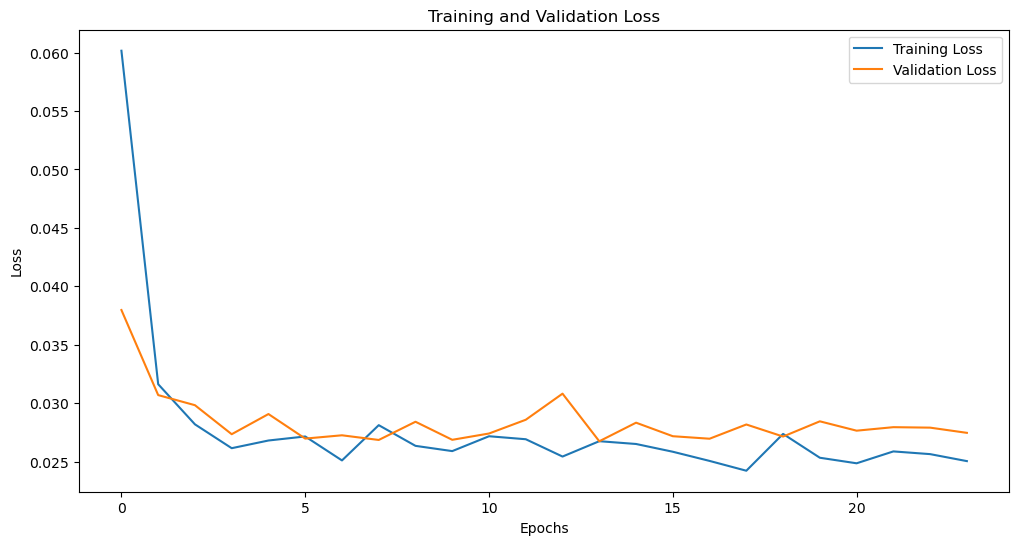

In [262]:
# 5. Plotting results
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

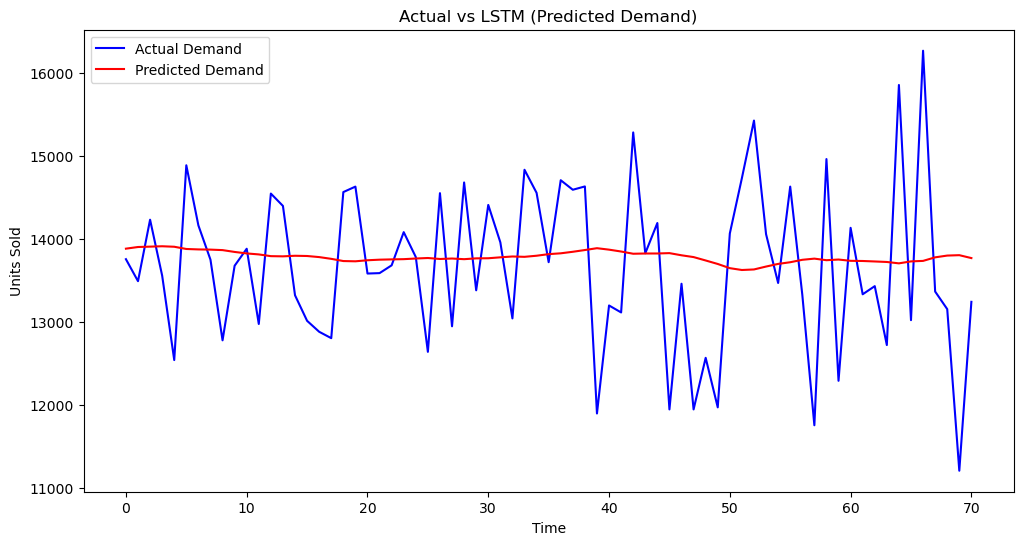

In [264]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual Demand', color='blue')
plt.plot(range(len(y_pred_rescaled)), y_pred_rescaled, label='Predicted Demand', color='red')
plt.title('Actual vs LSTM (Predicted Demand)')
plt.xlabel('Time')
plt.ylabel('Units Sold')
plt.legend()
plt.show()


## Inventory Optimization:

## Key Performance Indicators


Effective inventory management and demand forecasting rely on key performance indicators (KPIs) that provide actionable insights into inventory levels, costs, and demand patterns. Here are some real-life KPIs that can be predicted and used to manage inventory costs and forecast demand: 


Inventory Turnover Ratio: Measures how many times inventory is sold and replaced over a period.

Formula: $$\text{Inventory Turnover Ratio} = \frac{\text{Cost of Goods Sold (COGS)}}{\text{Average Inventory}}$$

Importance: High turnover indicates efficient inventory management, while low turnover suggests overstocking or sluggish sales.



Days Sales of Inventory (DSI)
Definition: Indicates the average number of days it takes to sell the entire inventory.

Formula: $$\text{DSI} = \frac{\text{Average Inventory}}{\text{COGS}} \times \text{365 days}$$

Importance: Helps in understanding how quickly inventory is turning into sales.

Optimal Order Quantity (EOQ)
Definition: The Economic Order Quantity (EOQ) is the ideal order quantity a company should purchase to minimize its total inventory costs, including ordering costs and holding costs.

Formula: $$EOQ = \sqrt{\frac{2DS}{H}}$$

where:

D= Demand rate (units per year)
S = Ordering cost per order
H = Holding cost per unit per year

Importance: EOQ helps businesses determine the optimal order size that minimizes the total inventory costs.


Safety Stock
Definition: Safety stock is the extra inventory held to mitigate the risk of stockouts caused by fluctuations in demand and supply lead times.

Formula: $$\text{Safety Stock} = Z \times \sigma_d \times \sqrt{L}$$

where:

Z = Z-score (the number of standard deviations from the mean, based on the desired service level).

std = Standard deviation of demand.

L = Lead time (in days)

Importance: Safety stock acts as a buffer against uncertainties in demand and supply.


Reorder Point
Definition: The reorder point is the inventory level at which a new order should be placed to replenish stock before it runs out.

Formula: $$\text{Reorder Point} = d \times L + \text{Safety Stock}$$

where:

d = Average daily demand.

L = Lead time (in days).

Importance: The reorder point ensures that new inventory is ordered at the right time to avoid stockouts.



Total Cost: The total cost represents the combined costs associated with inventory management. 


In [230]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import datetime


# Lets Calculate KPIs

ordering_cost = 100  # Per order
holding_cost = 10    # Per unit per year
lead_time =  7      # Days
z_score = 1.65      # For ~95% service level

time_series = retail.groupby('Date')['Units Sold'].sum()
COGS = retail['Units Sold'] * retail['Price']  
average_inventory = retail['Inventory Level'].mean()
average_daily_demand = time_series.mean()
std_dev_daily_demand = time_series.std()


# Forecast Annual Demand (Sum of next 365 days)
forecast_steps = 365
future_demand = model_fit.forecast(steps=forecast_steps)
annual_forecasted_demand = future_demand.sum()

# Days Sales of Inventory (DSI)
days_sales_inventory = average_inventory / COGS.sum() * 365


# Calculate EOQ
EOQ = np.sqrt((2 * annual_forecasted_demand * ordering_cost) / holding_cost)

# Calculate Safety Stock
safety_stock = z_score * std_dev_daily_demand * np.sqrt(lead_time)

# Calculate Reorder Point
reorder_point = (lead_time * average_daily_demand) + safety_stock

# Calculate Total Cost
total_cost = ((annual_forecasted_demand / EOQ) * ordering_cost) + ((EOQ / 2) * holding_cost)

# Print Results
print(f"Forecasted Annual Demand: {annual_forecasted_demand:.2f} units")
print(f"Optimal Order Quantity (EOQ): {EOQ:.2f} units")
print(f'Days Sales of Inventory (DSI): {days_sales_inventory:.2f} units')
print(f"Safety Stock: {safety_stock:.2f} units")
print(f"Reorder Point: {reorder_point:.2f} units")
print(f"Total Inventory Cost: ${total_cost:.2f}")


/Users/randinho/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/randinho/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/randinho/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Forecasted Annual Demand: 4977460.37 units
Optimal Order Quantity (EOQ): 9977.43 units
Days Sales of Inventory (DSI): 0.00 units
Safety Stock: 4505.01 units
Reorder Point: 100030.42 units
Total Inventory Cost: $99774.35
